In [58]:
import numpy as np
import matplotlib.pyplot as plt

In [59]:
%matplotlib inline

In [32]:
data1_parsed = np.load("data1.npz")

In [33]:
data1_parsed.files

['agri_military', 'labor', 'finance', 'health', 'gov', 'population_jobs']

In [84]:
labor = data1_parsed['labor']
agri_military = data1_parsed['agri_military']
health = data1_parsed['health']
finance = data1_parsed['finance']
gov = data1_parsed['gov']
population_jobs = data1_parsed['population_jobs']

In [37]:
set(labor['Series Code'])

{b'SL.TLF.TOTL.FE.ZS', b'SL.TLF.TOTL.IN'}

In [40]:
labor.dtype

dtype([('Series Name', 'S32'), ('Series Code', 'S32'), ('Country Name', 'S32'), ('Country Code', 'S32'), ('1991', '<f4'), ('1992', '<f4'), ('1993', '<f4'), ('1994', '<f4'), ('1995', '<f4'), ('1996', '<f4'), ('1997', '<f4'), ('1998', '<f4'), ('1999', '<f4'), ('2000', '<f4'), ('2001', '<f4'), ('2002', '<f4'), ('2003', '<f4'), ('2004', '<f4'), ('2005', '<f4'), ('2006', '<f4'), ('2007', '<f4'), ('2008', '<f4'), ('2009', '<f4'), ('2010', '<f4'), ('2011', '<f4'), ('2012', '<f4'), ('2013', '<f4'), ('2014', '<f4'), ('2015', '<f4')])

In [52]:
# Let's look at percentage of female workforce
female_wf = b'SL.TLF.TOTL.FE.ZS'
total_wf = b'SL.TLF.TOTL.IN'

In [147]:
# Parses year data in order given a row
def get_years(row):
    start_year = 2005
    end_year = 2014
    year_d = [[n, row[str(n)][0]] for n in range(start_year, end_year+1)]
    # remove any -1 values
    year_d = [d for d in year_d if d[1] != -1]
    return np.array(year_d)

In [148]:
us_wf = (labor['Series Code'] == total_wf) & (labor['Country Code'] == b"USA")
us_fe_wf = (labor['Series Code'] == female_wf) & (labor['Country Code'] == b"USA")

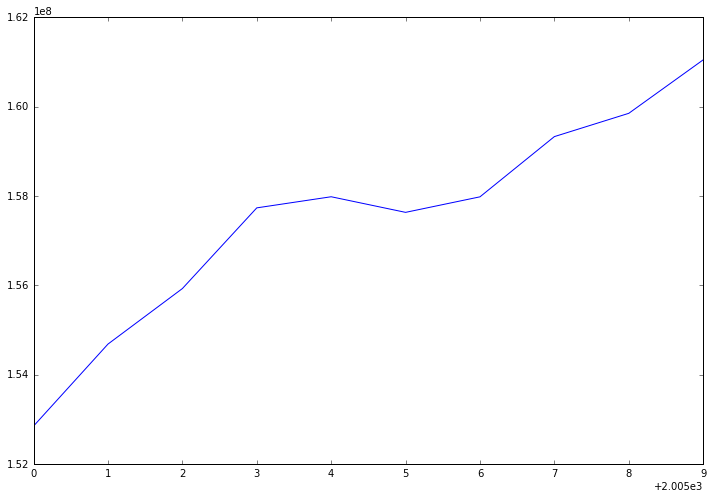

In [149]:
us_twf_years = get_years(labor[us_wf])
plt.plot(us_twf_years[:,0],us_twf_years[:,1])

In [150]:
dat = np.load("spreadsheets.npy")

In [20]:
import numpy as np
import matplotlib.pyplot as plt

dat = np.load("spreadsheets.npy")
years = [str(a) for a in range(1991,2030)]

maxyear = 2015
minyear = 2006
maxdeltay = 3

# Gets the X row, this is a super long row that contains all the delta slopes
def get_xrow(p_sc, cc, yearno):
    yearno_s = yearno - 1991

    # Generate a table for this SC
    xrow = []
    key = []
    # Loop through all other series codes excluding the current SC
    for sc in dat[(dat["Series Code"] != p_sc) | (dat['Country Code'] != cc)]:
        # Now we input the delta to the xrow
        for deltay in range(1,maxdeltay+1):
            xrow.append(sc[years[yearno_s - 1]] - sc[years[yearno_s - deltay - 1]])
            key.append(np.array([
                    sc["Series Code"],
                    sc["Country Code"],
                    years[yearno_s - 1],
                    years[yearno_s - deltay - 1]
                    ], dtype='S32'))
    return np.array(xrow), np.array(key)

# Same as get_xrow, but injects a spike
def get_xrow_with_spike(p_sc=None, p_cc=None, year=None, spike_sc=None, spike_cc=None, spike_amt=None):
    yearno_s = year - 1991
    # Generate a table for this SC
    xrow = []
    key = []
    # Loop through all other series codes excluding the current SC
    for sc in dat[(dat["Series Code"] != p_sc) | (dat['Country Code'] != p_cc)]:
        # Now we input the delta to the xrow
        for deltay in range(1,maxdeltay+1):
            if sc["Series Code"] == spike_sc and sc["Country Code"] == spike_cc:
                print(sc[years[yearno_s - 1]],
                      (sc[years[yearno_s - 1]] + spike_amt) - sc[years[yearno_s - deltay - 1]],
                      sc[years[yearno_s - 1]] + spike_amt,
                      sc[years[yearno_s - deltay - 1]])
                xrow.append((sc[years[yearno_s - 1]] + spike_amt) - sc[years[yearno_s - deltay - 1]])
            else:
                xrow.append(sc[years[yearno_s - 1]] - sc[years[yearno_s - deltay - 1]])
            key.append(np.array([
                    sc["Series Code"],
                    sc["Country Code"],
                    years[yearno_s - 1],
                    years[yearno_s - deltay - 1]
                    ], dtype='S32'))
    return np.array(xrow), np.array(key)

# Gets a single value for the y vector which is the "solution" matrix
# Takes a SC/Country that is being predicted and a year to get the increase in the SC for
def get_yval(p_sc, cc, yearno):
    yearno_s = yearno - 1991
    p_sc_years = dat[(dat["Series Code"] == p_sc) | (dat['Country Code'] == cc)][0]
    p_sc_inc = p_sc_years[years[yearno_s]] - p_sc_years[years[yearno_s - 1]]
    return p_sc_inc
    
def get_training_matrix(p_sc=b"SL.TLF.TOTL.FE.ZS", cc=b"USA"):

    # Loop through all the years we know this series code < maxyear
    sc_features = []
    sc_out = []
    
    # loop through all possible delta years
    for yearno in range(minyear + maxdeltay, maxyear):

        xrow,_ = get_xrow(p_sc, cc, yearno)
        sc_inc = get_yval(p_sc, cc, yearno)

        sc_features.append(xrow)
        sc_out.append(sc_inc)
        

    sc_features = np.array(sc_features)
    sc_out = np.array(sc_out)
    return sc_features, sc_out

# Get the value of a feature at a specific year
def get_feature_value(p_sc, cc, year, idat=None):
    if idat is None:
        idat = dat
    return idat[(dat["Series Code"] == p_sc) & (dat['Country Code'] == cc)][0][years[year-1991]]



# Adds a predicted year to the data using a list of corresponding series codes, country codes and 
# predicted values- this turns out to be a bit tricky
# def add_predicted_year(sc,cc,p_vals):
#     pass

In [21]:
open('data_matrix.py','w').write(In[-2])

3663

In [22]:
sc_features, sc_out = get_training_matrix(p_sc=b"BX.GSR.GNFS.CD", cc=b"USA")
sc_features.shape

(6, 39360)

In [190]:
sc_out.shape

(6,)

In [198]:
get_xrow(p_sc, cc, 2015)

array([ 0.09895539,  0.08040273,  0.21849203, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [161]:
for i in range(2005, 2015):
    print(i, get_feature_value(b"BX.GSR.GNFS.CD", b"USA", i))

2005 1.28602e+12
2006 1.45765e+12
2007 1.65355e+12
2008 1.84161e+12
2009 1.58305e+12
2010 1.8536e+12
2011 2.12702e+12
2012 2.21899e+12
2013 2.27994e+12
2014 2.3432e+12


In [142]:
dat[dat['Series Code'] == b"BX.GSR.GNFS.CD"]

array([], 
      dtype=[('Series Name', 'S32'), ('Series Code', 'S32'), ('Country Name', 'S32'), ('Country Code', 'S32'), ('1991', '<f4'), ('1992', '<f4'), ('1993', '<f4'), ('1994', '<f4'), ('1995', '<f4'), ('1996', '<f4'), ('1997', '<f4'), ('1998', '<f4'), ('1999', '<f4'), ('2000', '<f4'), ('2001', '<f4'), ('2002', '<f4'), ('2003', '<f4'), ('2004', '<f4'), ('2005', '<f4'), ('2006', '<f4'), ('2007', '<f4'), ('2008', '<f4'), ('2009', '<f4'), ('2010', '<f4'), ('2011', '<f4'), ('2012', '<f4'), ('2013', '<f4'), ('2014', '<f4'), ('2015', '<f4')])